In [1]:
import sys, time
print("Hello from Python", sys.version)
1 + 1

Hello from Python 3.13.7 (v3.13.7:bcee1c32211, Aug 14 2025, 19:10:51) [Clang 16.0.0 (clang-1600.0.26.6)]


2

In [2]:
import re, unicodedata
import numpy as np
import pandas as pd

CSV_PATH = "/Users/christen/Desktop/Python/Camp_Market.csv"
OUT_XLSX = "/Users/christen/Desktop/Python/Camp_Market_Segments.xlsx"
df = pd.read_csv(CSV_PATH)

df = pd.read_csv(CSV_PATH, sep=None, engine="python", encoding="utf-8-sig")

def clean_text(s: str) -> str:
    s = unicodedata.normalize("NFKC", str(s))
    s = s.replace("\u00A0", " ").replace("\u200b", "") 
    return s.strip()

orig_cols = list(df.columns)
df.columns = [clean_text(c) for c in df.columns]

def canon(s: str) -> str:
    return re.sub(r"[^0-9a-z]+", "", clean_text(s).lower())

col_canon = {c: canon(c) for c in df.columns}

print("Raw columns:", [repr(c) for c in orig_cols])
print("Cleaned columns:", list(df.columns))

id_candidates = []
for c, cc in col_canon.items():
    if cc in {"id", "custid", "customerid"} or cc.endswith("id"):
        id_candidates.append(c)

ID_COL = id_candidates[0] if id_candidates else None
if ID_COL is None:
    
    print("No clear ID column found — creating synthetic ID.")
    df["ID"] = np.arange(1, len(df) + 1)
    ID_COL = "ID"
elif ID_COL != "ID":
    df = df.rename(columns={ID_COL: "ID"})
    ID_COL = "ID"

date_candidates = []
for c, cc in col_canon.items():
    if cc in {"dtcustomer", "dt_customer"} or ("date" in cc and "birth" not in cc):
        date_candidates.append(c)

DATE_COL = date_candidates[0] if date_candidates else None
if DATE_COL is None:
    raise RuntimeError("Couldn't find the customer date column (e.g., Dt_Customer).")
elif DATE_COL != "Dt_Customer":
    df = df.rename(columns={DATE_COL: "Dt_Customer"})
    DATE_COL = "Dt_Customer"

print(f"Using ID column: {ID_COL!r}")
print(f"Using date column: {DATE_COL!r}")

df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"], dayfirst=True, errors="coerce")
df = df.sort_values("Dt_Customer", ascending=False).drop_duplicates(subset=["ID"], keep="first")

num_cols = [
    "Year_Birth","Income","Kidhome","Teenhome","Recency",
    "MntWines","MntFruits","MntMeatProducts","MntFishProducts",
    "MntSweetProducts","MntGoldProds","NumDealsPurchases",
    "NumWebPurchases","NumCatalogPurchases","NumStorePurchases",
    "NumWebVisitsMonth","AcceptedCmp3","AcceptedCmp4","AcceptedCmp5",
    "AcceptedCmp1","AcceptedCmp2","Complain","Z_CostContact","Z_Revenue","Response"
]
for c in [c for c in num_cols if c in df.columns]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

today = pd.Timestamp("today").normalize()
this_year = today.year
if "Year_Birth" in df.columns:
    df.loc[~df["Year_Birth"].between(1900, this_year), "Year_Birth"] = np.nan
    df["Year_Birth"] = df["Year_Birth"].fillna(round(df["Year_Birth"].median()))
if "Income" in df.columns:
    df["Income"] = df["Income"].fillna(df["Income"].median())
for c in ["Education","Marital_Status"]:
    if c in df.columns and df[c].dtype == object:
        df[c] = df[c].str.strip().replace({"2n Cycle":"2nd Cycle"})

if "Year_Birth" in df.columns:
    df["Age"] = today.year - df["Year_Birth"].astype(int)
if {"Kidhome","Teenhome"}.issubset(df.columns):
    df["KidsTotal"] = df["Kidhome"].fillna(0) + df["Teenhome"].fillna(0)
df["TenureYears"] = ((today - df["Dt_Customer"]).dt.days / 365.25).round(1)

spend_cols = [c for c in ["MntWines","MntFruits","MntMeatProducts","MntFishProducts","MntSweetProducts","MntGoldProds"] if c in df.columns]
df["TotalSpend"] = df[spend_cols].sum(axis=1) if spend_cols else 0

if "Marital_Status" in df.columns:
    df["FamilyStatus"] = df["Marital_Status"].replace({
        "Married":"Couple","Together":"Couple",
        "Single":"Single","Divorced":"Single","Widow":"Single",
        "Alone":"Single","Absurd":"Other","YOLO":"Other"
    })

if "Age" in df.columns:
    age_labels = ["<25","25–34","35–44","45–54","55–64","65+"]
    df["AgeGroup"] = pd.Categorical(
        pd.cut(df["Age"], bins=[0,25,35,45,55,65,200], labels=age_labels, include_lowest=True),
        categories=age_labels, ordered=True
    )

if "Income" in df.columns:
    income_labels = ["≤30k","30–60k","60–90k","90–120k","120k+"]
    df["IncomeBand"] = pd.Categorical(
        pd.cut(df["Income"], bins=[-np.inf,30000,60000,90000,120000,np.inf], labels=income_labels),
        categories=income_labels, ordered=True
    )

if "Education" in df.columns:
    edu_order = ["Basic","2nd Cycle","Graduation","Master","PhD"]
    df["Education"] = pd.Categorical(df["Education"], categories=edu_order, ordered=True)

sort_cols = [c for c in ["AgeGroup","IncomeBand","Education","TotalSpend"] if c in df.columns]
ascending = [True, True, True, False][:len(sort_cols)]
sorted_df = df.sort_values(sort_cols, ascending=ascending).reset_index(drop=True)

group_cols = [c for c in ["AgeGroup","IncomeBand","Education","FamilyStatus"] if c in sorted_df.columns]
segment_summary = (
    sorted_df.groupby(group_cols, dropna=False)
    .agg(Customers=("ID","count"),
         AvgIncome=("Income","mean") if "Income" in sorted_df.columns else ("ID","size"),
         AvgSpend=("TotalSpend","mean"))
    .reset_index()
) if group_cols else pd.DataFrame()

with pd.ExcelWriter(OUT_XLSX, engine="xlsxwriter") as writer:
    sorted_df.to_excel(writer, sheet_name="Sorted Data", index=False)
    if not segment_summary.empty:
        segment_summary.to_excel(writer, sheet_name="Segment Summary", index=False)

    for name, d in [("Sorted Data", sorted_df)] + ([("Segment Summary", segment_summary)] if not segment_summary.empty else []):
        ws = writer.sheets[name]
        ws.freeze_panes(1, 0)
        ws.autofilter(0, 0, len(d), len(d.columns)-1)
        for i, col in enumerate(d.columns):
            width = min(max(len(str(col)), d[col].astype(str).map(len).head(10000).max()) + 2, 50)
            ws.set_column(i, i, width)

print(f"Done → {OUT_XLSX}")

Raw columns: ["'ID'", "'Year_Birth'", "'Education'", "'Marital_Status'", "'Income'", "'Kidhome'", "'Teenhome'", "'Dt_Customer'", "'Recency'", "'MntWines'", "'MntFruits'", "'MntMeatProducts'", "'MntFishProducts'", "'MntSweetProducts'", "'MntGoldProds'", "'NumDealsPurchases'", "'NumWebPurchases'", "'NumCatalogPurchases'", "'NumStorePurchases'", "'NumWebVisitsMonth'", "'AcceptedCmp3'", "'AcceptedCmp4'", "'AcceptedCmp5'", "'AcceptedCmp1'", "'AcceptedCmp2'", "'Complain'", "'Z_CostContact'", "'Z_Revenue'", "'Response'"]
Cleaned columns: ['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response']
Using ID colum

/var/folders/mk/ww189qgj2ps6l7xfy3sc3g700000gn/T/ipykernel_76763/3537790094.py:122: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sorted_df.groupby(group_cols, dropna=False)


Done → /Users/christen/Desktop/Python/Camp_Market_Segments.xlsx


In [ ]:
import pandas as pd
import numpy as np

base = sorted_df.copy() if 'sorted_df' in globals() else df.copy()

num_cols = [c for c in [
    "Income","Response","Recency","TotalSpend",
    "NumWebPurchases","NumStorePurchases","NumCatalogPurchases","NumDealsPurchases","NumWebVisitsMonth"
] if c in base.columns]
base[num_cols] = base[num_cols].fillna(0)

base["TotalPurchases"] = 0
for c in ["NumWebPurchases","NumStorePurchases","NumCatalogPurchases"]:
    if c in base.columns:
        base["TotalPurchases"] = base["TotalPurchases"] + base[c]

kpis = {}

kpis["Customers"] = base["ID"].nunique() if "ID" in base.columns else len(base)
kpis["ResponseRate"] = base["Response"].mean() if "Response" in base.columns else np.nan
kpis["AvgIncome"] = base["Income"].mean() if "Income" in base.columns else np.nan
kpis["TotalRevenueProxy"] = base["TotalSpend"].sum() if "TotalSpend" in base.columns else np.nan

purchases = base["TotalPurchases"].sum()
revenue = base["TotalSpend"].sum() if "TotalSpend" in base.columns else np.nan

kpis["TotalPurchases"] = purchases
kpis["AvgFrequency_per_Customer"] = purchases / max(kpis["Customers"], 1)
kpis["AOV_proxy"] = (revenue / purchases) if purchases > 0 else np.nan
kpis["AvgRecency_days"] = base["Recency"].mean() if "Recency" in base.columns else np.nan
kpis["DealRate"] = (base["NumDealsPurchases"].sum() / purchases) if ("NumDealsPurchases" in base.columns and purchases>0) else np.nan
kpis["WebConversion_proxy"] = (base["NumWebPurchases"].sum() / (base["NumWebVisitsMonth"].sum() + 1)) if {"NumWebPurchases","NumWebVisitsMonth"}.issubset(base.columns) else np.nan

kpi_table = pd.DataFrame.from_dict(kpis, orient="index", columns=["Value"])
kpi_table

,Value
Customers,2.240000e+03
ResponseRate,1.491071e-01
AvgIncome,5.223798e+04
TotalRevenueProxy,1.356988e+06
TotalPurchases,2.808300e+04
AvgFrequency_per_Customer,1.253705e+01
AOV_proxy,4.832062e+01
AvgRecency_days,4.910938e+01
DealRate,1.854503e-01
WebConversion_proxy,7.682620e-01


In [4]:
group_cols = [c for c in ["AgeGroup","IncomeBand","Education"] if c in base.columns]
agg_dict = {}

if "ID" in base.columns: agg_dict["Customers"] = ("ID","nunique")
if "Response" in base.columns: agg_dict["ResponseRate"] = ("Response","mean")
if "Income" in base.columns: agg_dict["AvgIncome"] = ("Income","mean")
if "TotalSpend" in base.columns: agg_dict["AvgSpend"] = ("TotalSpend","mean")
if {"NumWebPurchases","NumStorePurchases","NumCatalogPurchases"}.issubset(base.columns):
    base["TotalPurchases"] = base["NumWebPurchases"] + base["NumStorePurchases"] + base["NumCatalogPurchases"]
    agg_dict["AvgFrequency"] = ("TotalPurchases","mean")
if "Recency" in base.columns: agg_dict["AvgRecency"] = ("Recency","mean")

seg_kpis = (base.groupby(group_cols, dropna=False)
               .agg(**agg_dict)
               .reset_index()
               .sort_values(group_cols))
seg_kpis.head(12)


/var/folders/mk/ww189qgj2ps6l7xfy3sc3g700000gn/T/ipykernel_73256/1177602636.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seg_kpis = (base.groupby(group_cols, dropna=False)


,AgeGroup,IncomeBand,Education,Customers,ResponseRate,AvgIncome,AvgSpend,AvgFrequency,AvgRecency
0,<25,≤30k,Basic,0,NaN,NaN,NaN,NaN,NaN
1,<25,≤30k,2nd Cycle,0,NaN,NaN,NaN,NaN,NaN
2,<25,≤30k,Graduation,0,NaN,NaN,NaN,NaN,NaN
3,<25,≤30k,Master,0,NaN,NaN,NaN,NaN,NaN
4,<25,≤30k,PhD,0,NaN,NaN,NaN,NaN,NaN
5,<25,30–60k,Basic,0,NaN,NaN,NaN,NaN,NaN
6,<25,30–60k,2nd Cycle,0,NaN,NaN,NaN,NaN,NaN
7,<25,30–60k,Graduation,0,NaN,NaN,NaN,NaN,NaN
8,<25,30–60k,Master,0,NaN,NaN,NaN,NaN,NaN
9,<25,30–60k,PhD,0,NaN,NaN,NaN,NaN,NaN


In [6]:
import pandas as pd
import numpy as np
import re, unicodedata


if 'sorted_df' in globals():
    base = sorted_df.copy()
elif 'df' in globals():
    base = df.copy()
else:
    base = pd.read_csv("/Users/christen/Desktop/Python/Camp_Market.csv", sep=None, engine="python")


def clean_text(s: str) -> str:
    s = unicodedata.normalize("NFKC", str(s))
    s = s.replace("\u00A0"," ").replace("\u200b","")
    return s.strip()

base.columns = [clean_text(c) for c in base.columns]

def canon(s:str)->str:
    return re.sub(r"[^0-9a-z]+","", clean_text(s).lower())

resp_col = next((c for c in base.columns if canon(c)=="response"), None)
if resp_col and resp_col != "Response":
    base = base.rename(columns={resp_col:"Response"})

inc_col  = next((c for c in base.columns if canon(c)=="income"), None)
if inc_col and inc_col != "Income":
    base = base.rename(columns={inc_col:"Income"})

rec_col  = next((c for c in base.columns if canon(c)=="recency"), None)
if rec_col and rec_col != "Recency":
    base = base.rename(columns={rec_col:"Recency"})

to_num = ["Income","Recency","NumWebPurchases","NumStorePurchases","NumCatalogPurchases",
          "NumDealsPurchases","NumWebVisitsMonth","TotalSpend"]
for c in to_num:
    if c in base.columns:
        base[c] = pd.to_numeric(base[c], errors="coerce")

if "Response" in base.columns:
    if base["Response"].dtype == object:
        base["Response"] = (base["Response"]
            .astype(str).str.strip().str.lower()
            .replace({"yes":1,"no":0,"true":1,"false":0,"y":1,"n":0,"1":1,"0":0,"":np.nan}))
    base["Response"] = pd.to_numeric(base["Response"], errors="coerce").fillna(0).astype(int)

if "TotalSpend" not in base.columns:
    spend_cols = [c for c in ["MntWines","MntFruits","MntMeatProducts",
                              "MntFishProducts","MntSweetProducts","MntGoldProds"]
                  if c in base.columns]
    base["TotalSpend"] = base[spend_cols].sum(axis=1) if spend_cols else 0

have_purch_cols = {"NumWebPurchases","NumStorePurchases","NumCatalogPurchases"}.issubset(base.columns)
if have_purch_cols:
    base["TotalPurchases"] = (base["NumWebPurchases"].fillna(0) +
                              base["NumStorePurchases"].fillna(0) +
                              base["NumCatalogPurchases"].fillna(0))
else:
    base["TotalPurchases"] = 0

kpis = {}

kpis["Customers"] = base["ID"].nunique() if "ID" in base.columns else len(base)
kpis["ResponseRate"] = base["Response"].mean() if "Response" in base.columns else np.nan
kpis["AvgIncome"] = base["Income"].mean() if "Income" in base.columns else np.nan
kpis["TotalRevenueProxy"] = base["TotalSpend"].sum()
kpis["TotalPurchases"] = base["TotalPurchases"].sum()
kpis["AvgFrequency_per_Customer"] = kpis["TotalPurchases"] / max(kpis["Customers"],1)
kpis["AOV_proxy"] = (kpis["TotalRevenueProxy"] / kpis["TotalPurchases"]) if kpis["TotalPurchases"]>0 else np.nan
kpis["AvgRecency_days"] = base["Recency"].mean() if "Recency" in base.columns else np.nan
kpis["DealRate"] = (base["NumDealsPurchases"].sum() / kpis["TotalPurchases"]) if ("NumDealsPurchases" in base.columns and kpis["TotalPurchases"]>0) else np.nan
kpis["WebConversion_proxy"] = (base["NumWebPurchases"].sum() / (base["NumWebVisitsMonth"].sum()+1)) if {"NumWebPurchases","NumWebVisitsMonth"}.issubset(base.columns) else np.nan

kpi_table = pd.DataFrame.from_dict(kpis, orient="index", columns=["Value"]).round(4)
display(kpi_table)

group_cols = [c for c in ["AgeGroup","IncomeBand","Education"] if c in base.columns]
if group_cols:
    seg_kpis = (base.groupby(group_cols, dropna=False)
                    .agg(Customers=("ID","nunique") if "ID" in base.columns else ("TotalSpend","size"),
                         ResponseRate=("Response","mean") if "Response" in base.columns else ("TotalSpend","mean"),
                         AvgIncome=("Income","mean") if "Income" in base.columns else ("TotalSpend","mean"),
                         AvgSpend=("TotalSpend","mean"),
                         AvgFrequency=("TotalPurchases","mean"),
                         AvgRecency=("Recency","mean") if "Recency" in base.columns else ("TotalSpend","mean"))
                    .reset_index())
    display(seg_kpis.head(12))
else:
    print("Note: segment columns not present; skipping segment KPIs.")

,Value
Customers,2.240000e+03
ResponseRate,1.491000e-01
AvgIncome,5.223798e+04
TotalRevenueProxy,1.356988e+06
TotalPurchases,2.808300e+04
AvgFrequency_per_Customer,1.253710e+01
AOV_proxy,4.832060e+01
AvgRecency_days,4.910940e+01
DealRate,1.855000e-01
WebConversion_proxy,7.683000e-01


/var/folders/mk/ww189qgj2ps6l7xfy3sc3g700000gn/T/ipykernel_73256/3013407367.py:81: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seg_kpis = (base.groupby(group_cols, dropna=False)


,AgeGroup,IncomeBand,Education,Customers,ResponseRate,AvgIncome,AvgSpend,AvgFrequency,AvgRecency
0,<25,≤30k,Basic,0,NaN,NaN,NaN,NaN,NaN
1,<25,≤30k,2nd Cycle,0,NaN,NaN,NaN,NaN,NaN
2,<25,≤30k,Graduation,0,NaN,NaN,NaN,NaN,NaN
3,<25,≤30k,Master,0,NaN,NaN,NaN,NaN,NaN
4,<25,≤30k,PhD,0,NaN,NaN,NaN,NaN,NaN
5,<25,30–60k,Basic,0,NaN,NaN,NaN,NaN,NaN
6,<25,30–60k,2nd Cycle,0,NaN,NaN,NaN,NaN,NaN
7,<25,30–60k,Graduation,0,NaN,NaN,NaN,NaN,NaN
8,<25,30–60k,Master,0,NaN,NaN,NaN,NaN,NaN
9,<25,30–60k,PhD,0,NaN,NaN,NaN,NaN,NaN


In [7]:
import pandas as pd
import numpy as np
import re, unicodedata


if 'sorted_df' in globals():
    base = sorted_df.copy()
elif 'df' in globals():
    base = df.copy()
else:
    base = pd.read_csv("/Users/christen/Desktop/Python/Camp_Market.csv", sep=None, engine="python")

def clean_text(s: str) -> str:
    s = unicodedata.normalize("NFKC", str(s))
    s = s.replace("\u00A0"," ").replace("\u200b","")
    return s.strip()

base.columns = [clean_text(c) for c in base.columns]

def canon(s:str)->str:
    return re.sub(r"[^0-9a-z]+","", clean_text(s).lower())

resp_col = next((c for c in base.columns if canon(c)=="response"), None)
if resp_col and resp_col != "Response":
    base = base.rename(columns={resp_col:"Response"})

inc_col  = next((c for c in base.columns if canon(c)=="income"), None)
if inc_col and inc_col != "Income":
    base = base.rename(columns={inc_col:"Income"})

rec_col  = next((c for c in base.columns if canon(c)=="recency"), None)
if rec_col and rec_col != "Recency":
    base = base.rename(columns={rec_col:"Recency"})

to_num = ["Income","Recency","NumWebPurchases","NumStorePurchases","NumCatalogPurchases",
          "NumDealsPurchases","NumWebVisitsMonth","TotalSpend"]
for c in to_num:
    if c in base.columns:
        base[c] = pd.to_numeric(base[c], errors="coerce")

if "Response" in base.columns:
    if base["Response"].dtype == object:
        base["Response"] = (base["Response"]
            .astype(str).str.strip().str.lower()
            .replace({"yes":1,"no":0,"true":1,"false":0,"y":1,"n":0,"1":1,"0":0,"":np.nan}))
    base["Response"] = pd.to_numeric(base["Response"], errors="coerce").fillna(0).astype(int)

if "TotalSpend" not in base.columns:
    spend_cols = [c for c in ["MntWines","MntFruits","MntMeatProducts",
                              "MntFishProducts","MntSweetProducts","MntGoldProds"]
                  if c in base.columns]
    base["TotalSpend"] = base[spend_cols].sum(axis=1) if spend_cols else 0

have_purch_cols = {"NumWebPurchases","NumStorePurchases","NumCatalogPurchases"}.issubset(base.columns)
if have_purch_cols:
    base["TotalPurchases"] = (base["NumWebPurchases"].fillna(0) +
                              base["NumStorePurchases"].fillna(0) +
                              base["NumCatalogPurchases"].fillna(0))
else:
    base["TotalPurchases"] = 0

kpis = {}

kpis["Customers"] = base["ID"].nunique() if "ID" in base.columns else len(base)
kpis["ResponseRate"] = base["Response"].mean() if "Response" in base.columns else np.nan
kpis["AvgIncome"] = base["Income"].mean() if "Income" in base.columns else np.nan
kpis["TotalRevenueProxy"] = base["TotalSpend"].sum()
kpis["TotalPurchases"] = base["TotalPurchases"].sum()
kpis["AvgFrequency_per_Customer"] = kpis["TotalPurchases"] / max(kpis["Customers"],1)
kpis["AOV_proxy"] = (kpis["TotalRevenueProxy"] / kpis["TotalPurchases"]) if kpis["TotalPurchases"]>0 else np.nan
kpis["AvgRecency_days"] = base["Recency"].mean() if "Recency" in base.columns else np.nan
kpis["DealRate"] = (base["NumDealsPurchases"].sum() / kpis["TotalPurchases"]) if ("NumDealsPurchases" in base.columns and kpis["TotalPurchases"]>0) else np.nan
kpis["WebConversion_proxy"] = (base["NumWebPurchases"].sum() / (base["NumWebVisitsMonth"].sum()+1)) if {"NumWebPurchases","NumWebVisitsMonth"}.issubset(base.columns) else np.nan

kpi_table = pd.DataFrame.from_dict(kpis, orient="index", columns=["Value"]).round(4)
display(kpi_table)

group_cols = [c for c in ["AgeGroup","IncomeBand","Education"] if c in base.columns]
if group_cols:
    seg_kpis = (base.groupby(group_cols, dropna=False)
                    .agg(Customers=("ID","nunique") if "ID" in base.columns else ("TotalSpend","size"),
                         ResponseRate=("Response","mean") if "Response" in base.columns else ("TotalSpend","mean"),
                         AvgIncome=("Income","mean") if "Income" in base.columns else ("TotalSpend","mean"),
                         AvgSpend=("TotalSpend","mean"),
                         AvgFrequency=("TotalPurchases","mean"),
                         AvgRecency=("Recency","mean") if "Recency" in base.columns else ("TotalSpend","mean"))
                    .reset_index())
    display(seg_kpis.head(12))
else:
    print("Note: segment columns not present; skipping segment KPIs.")

,Value
Customers,2.240000e+03
ResponseRate,1.491000e-01
AvgIncome,5.223798e+04
TotalRevenueProxy,1.356988e+06
TotalPurchases,2.808300e+04
AvgFrequency_per_Customer,1.253710e+01
AOV_proxy,4.832060e+01
AvgRecency_days,4.910940e+01
DealRate,1.855000e-01
WebConversion_proxy,7.683000e-01


/var/folders/mk/ww189qgj2ps6l7xfy3sc3g700000gn/T/ipykernel_73256/4060484661.py:80: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seg_kpis = (base.groupby(group_cols, dropna=False)


,AgeGroup,IncomeBand,Education,Customers,ResponseRate,AvgIncome,AvgSpend,AvgFrequency,AvgRecency
0,<25,≤30k,Basic,0,NaN,NaN,NaN,NaN,NaN
1,<25,≤30k,2nd Cycle,0,NaN,NaN,NaN,NaN,NaN
2,<25,≤30k,Graduation,0,NaN,NaN,NaN,NaN,NaN
3,<25,≤30k,Master,0,NaN,NaN,NaN,NaN,NaN
4,<25,≤30k,PhD,0,NaN,NaN,NaN,NaN,NaN
5,<25,30–60k,Basic,0,NaN,NaN,NaN,NaN,NaN
6,<25,30–60k,2nd Cycle,0,NaN,NaN,NaN,NaN,NaN
7,<25,30–60k,Graduation,0,NaN,NaN,NaN,NaN,NaN
8,<25,30–60k,Master,0,NaN,NaN,NaN,NaN,NaN
9,<25,30–60k,PhD,0,NaN,NaN,NaN,NaN,NaN


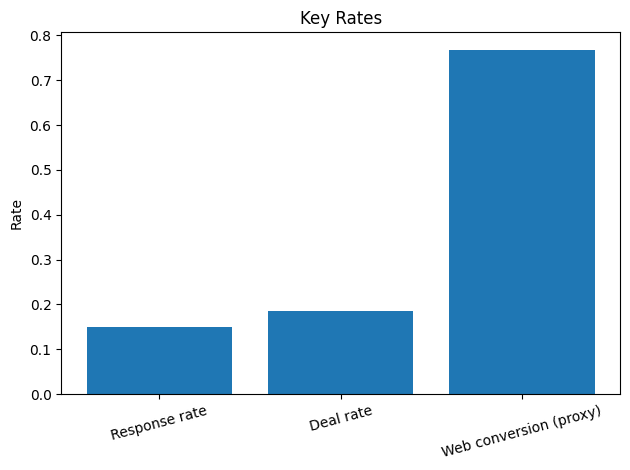

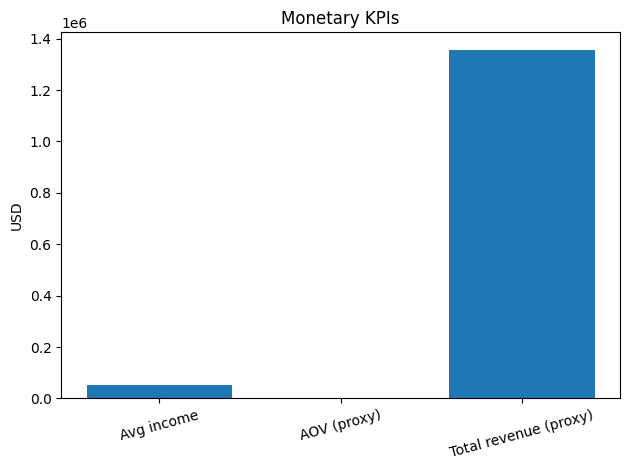

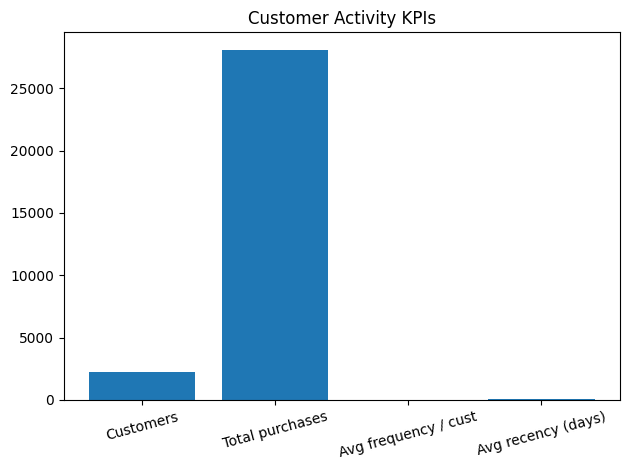

Saved: kpi_rates.png, kpi_money.png, kpi_activity.png


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

if 'kpi_table' not in globals():
    raise RuntimeError("Run the KPI cell first to create `kpi_table`.")

pct = kpi_table.loc[["ResponseRate","DealRate","WebConversion_proxy"], "Value"].rename({
    "ResponseRate":"Response rate",
    "DealRate":"Deal rate",
    "WebConversion_proxy":"Web conversion (proxy)"
})
plt.figure()
plt.bar(pct.index, pct.values)
plt.title("Key Rates")
plt.ylabel("Rate")
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig("kpi_rates.png", dpi=150)
plt.show()

monetary = kpi_table.loc[["AvgIncome","AOV_proxy","TotalRevenueProxy"], "Value"].rename({
    "AvgIncome":"Avg income",
    "AOV_proxy":"AOV (proxy)",
    "TotalRevenueProxy":"Total revenue (proxy)"
})
plt.figure()
plt.bar(monetary.index, monetary.values)
plt.title("Monetary KPIs")
plt.ylabel("USD")
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig("kpi_money.png", dpi=150)
plt.show()

activity = kpi_table.loc[["Customers","TotalPurchases","AvgFrequency_per_Customer","AvgRecency_days"], "Value"].rename({
    "Customers":"Customers",
    "TotalPurchases":"Total purchases",
    "AvgFrequency_per_Customer":"Avg frequency / cust",
    "AvgRecency_days":"Avg recency (days)"
})
plt.figure()
plt.bar(activity.index, activity.values)
plt.title("Customer Activity KPIs")
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig("kpi_activity.png", dpi=150)
plt.show()

print("Saved: kpi_rates.png, kpi_money.png, kpi_activity.png")

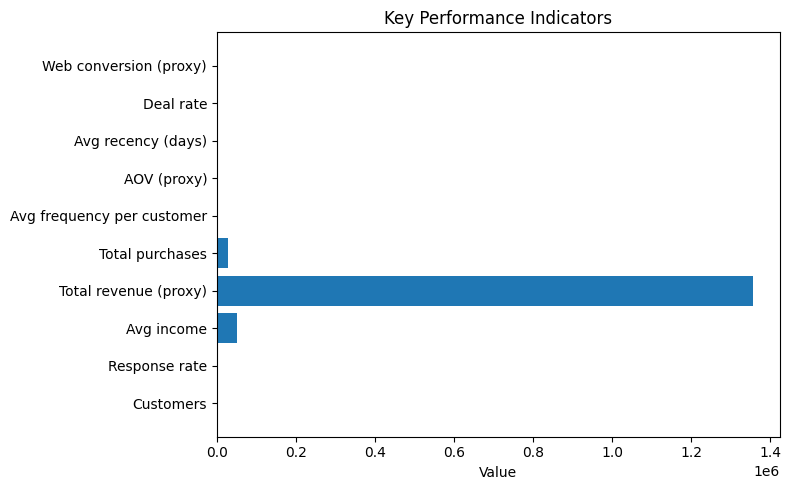

In [9]:
kt = kpi_table["Value"].copy()

labels = [
    "Customers","Response rate","Avg income","Total revenue (proxy)",
    "Total purchases","Avg frequency per customer","AOV (proxy)",
    "Avg recency (days)","Deal rate","Web conversion (proxy)"
]
keys = ["Customers","ResponseRate","AvgIncome","TotalRevenueProxy",
        "TotalPurchases","AvgFrequency_per_Customer","AOV_proxy",
        "AvgRecency_days","DealRate","WebConversion_proxy"]
vals = [kt.get(k, np.nan) for k in keys]

plt.figure(figsize=(8,5))
plt.barh(labels, vals)
plt.title("Key Performance Indicators")
plt.xlabel("Value")
plt.tight_layout()
plt.show()

/var/folders/mk/ww189qgj2ps6l7xfy3sc3g700000gn/T/ipykernel_73256/2298713380.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resp_by_age = base.groupby("AgeGroup")["Response"].mean()


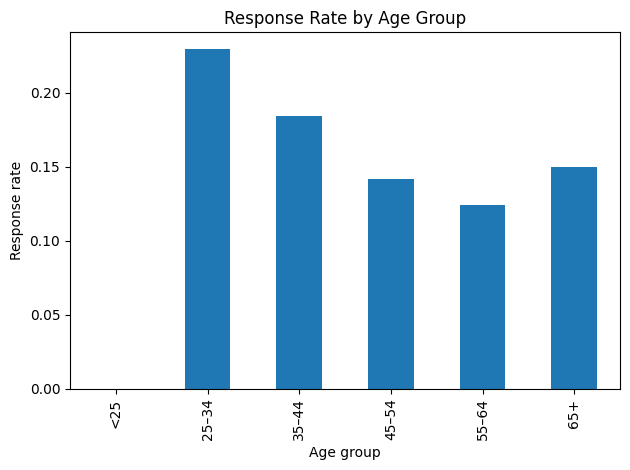

In [10]:
base = sorted_df.copy() if 'sorted_df' in globals() else df.copy()

if {"AgeGroup","Response"}.issubset(base.columns):
    resp_by_age = base.groupby("AgeGroup")["Response"].mean()
    resp_by_age.plot(kind="bar", title="Response Rate by Age Group")
    plt.ylabel("Response rate")
    plt.xlabel("Age group")
    plt.tight_layout()
    plt.show()

/var/folders/mk/ww189qgj2ps6l7xfy3sc3g700000gn/T/ipykernel_73256/1601597594.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = (base.pivot_table(index="AgeGroup", columns="IncomeBand",


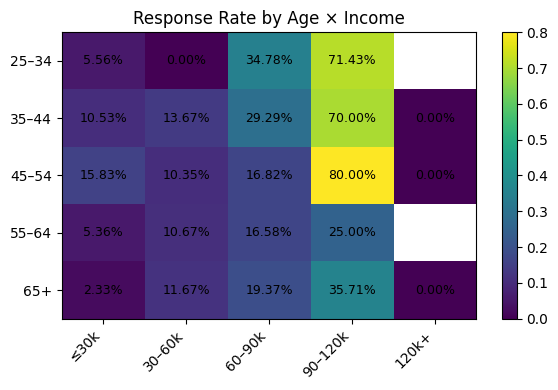

In [11]:
if {"AgeGroup","IncomeBand","Response"}.issubset(base.columns):
    pivot = (base.pivot_table(index="AgeGroup", columns="IncomeBand",
                              values="Response", aggfunc="mean"))
    plt.figure(figsize=(6,4))
    plt.imshow(pivot, aspect="auto")
    plt.title("Response Rate by Age × Income")
    plt.xticks(range(pivot.shape[1]), pivot.columns, rotation=45, ha="right")
    plt.yticks(range(pivot.shape[0]), pivot.index)
    for i in range(pivot.shape[0]):
        for j in range(pivot.shape[1]):
            val = pivot.iloc[i, j]
            if pd.notna(val):
                plt.text(j, i, f"{val:.2%}", ha="center", va="center", fontsize=9)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

/var/folders/mk/ww189qgj2ps6l7xfy3sc3g700000gn/T/ipykernel_73256/3308710453.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prod = base.groupby("AgeGroup")[spend_cols].mean().fillna(0)


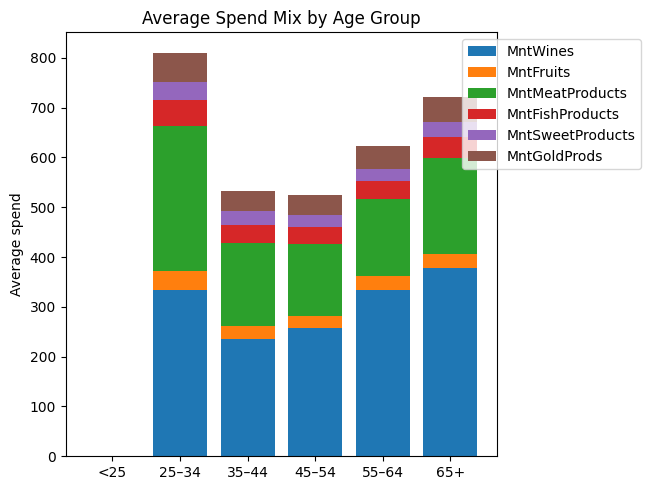

In [12]:
spend_cols = [c for c in ["MntWines","MntFruits","MntMeatProducts",
                          "MntFishProducts","MntSweetProducts","MntGoldProds"]
              if c in base.columns]

if "AgeGroup" in base.columns and spend_cols:
    prod = base.groupby("AgeGroup")[spend_cols].mean().fillna(0)
    bottom = np.zeros(len(prod))
    plt.figure(figsize=(7,5))
    for col in spend_cols:
        plt.bar(prod.index.astype(str), prod[col].values, bottom=bottom, label=col)
        bottom += prod[col].values
    plt.title("Average Spend Mix by Age Group")
    plt.ylabel("Average spend")
    plt.legend(loc="upper right", bbox_to_anchor=(1.35, 1.0))
    plt.tight_layout()
    plt.show()

In [4]:
df['Education'] = df['Education'].replace({
    'Basic': 'High School',
    '2nd Cycle': 'Middle School'
})

/var/folders/mk/ww189qgj2ps6l7xfy3sc3g700000gn/T/ipykernel_76763/4074338371.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['Education'] = df['Education'].replace({


In [8]:
df.head(20).style.hide(axis="index") 

ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age,KidsTotal,TenureYears,TotalSpend,FamilyStatus,AgeGroup,IncomeBand
7300,1952.000000,Graduation,Divorced,69142.000000,0,1,2014-06-29 00:00:00,50,448,4,34,6,4,39,3,8,1,7,5,0,1,0,0,0,0,3,11,0,73,1,11.300000,535,Single,65+,60–90k
453,1956.000000,PhD,Widow,35340.000000,1,1,2014-06-29 00:00:00,1,27,0,12,0,1,5,2,2,0,3,5,0,0,0,0,0,0,3,11,0,69,2,11.300000,45,Single,65+,30–60k
8093,1969.000000,Master,Married,79734.000000,0,0,2014-06-28 00:00:00,72,572,8,232,23,62,17,1,4,3,6,1,0,0,0,1,0,0,3,11,0,56,0,11.300000,914,Couple,55–64,60–90k
6722,1954.000000,PhD,Married,70421.000000,0,1,2014-06-28 00:00:00,98,479,28,136,75,14,35,3,10,3,7,6,0,0,0,0,0,0,3,11,0,71,1,11.300000,767,Couple,65+,60–90k
1371,1976.000000,Graduation,Single,79941.000000,0,0,2014-06-28 00:00:00,72,123,164,266,227,30,174,1,2,4,9,1,0,0,0,0,0,0,3,11,0,49,0,11.300000,984,Single,45–54,60–90k
2471,1965.000000,Graduation,Married,61482.000000,0,0,2014-06-27 00:00:00,39,48,58,68,16,66,43,1,3,2,6,2,0,0,0,0,0,0,3,11,0,60,0,11.300000,299,Couple,55–64,60–90k
2831,1976.000000,Graduation,Together,78416.000000,0,1,2014-06-27 00:00:00,99,453,38,279,188,38,183,2,7,7,10,3,0,0,0,0,0,0,3,11,0,49,1,11.300000,1179,Couple,45–54,60–90k
4472,1970.000000,PhD,Divorced,35682.000000,1,0,2014-06-27 00:00:00,34,23,0,8,6,2,18,1,1,1,3,2,0,0,0,0,0,0,3,11,0,55,1,11.300000,57,Single,45–54,30–60k
9014,1975.000000,Graduation,Married,37085.000000,1,1,2014-06-26 00:00:00,65,39,1,16,2,0,3,4,3,0,3,8,0,0,0,0,0,0,3,11,0,50,2,11.300000,61,Couple,45–54,30–60k
7059,1963.000000,Graduation,Married,80124.000000,0,0,2014-06-26 00:00:00,47,483,84,398,205,84,241,1,3,7,8,1,1,0,0,0,0,0,3,11,0,62,0,11.300000,1495,Couple,55–64,60–90k


In [12]:
df = pd.read_csv(CSV_PATH)

In [20]:
for i, c in enumerate(df.columns):
    print(i, repr(c))

0 'ID;Year_Birth;Education;Marital_Status;Income;Kidhome;Teenhome;Dt_Customer;Recency;MntWines;MntFruits;MntMeatProducts;MntFishProducts;MntSweetProducts;MntGoldProds;NumDealsPurchases;NumWebPurchases;NumCatalogPurchases;NumStorePurchases;NumWebVisitsMonth;AcceptedCmp3;AcceptedCmp4;AcceptedCmp5;AcceptedCmp1;AcceptedCmp2;Complain;Z_CostContact;Z_Revenue;Response'


In [22]:
import pandas as pd

df = pd.read_csv(CSV_PATH, sep=';', encoding='utf-8-sig')

In [23]:
import re, unicodedata

def clean_columns(df):
    def norm(s):
        s = str(s)
        s = unicodedata.normalize("NFKC", s)
        s = s.replace("\xa0", " ")
        s = re.sub(r"\s+", " ", s)
        return s.strip()
    df = df.copy()
    df.columns = [norm(c) for c in df.columns]
    return df

df = clean_columns(df)

In [28]:
df['Education'] = df['Education'].replace({
    'Basic': 'Middle School',
    '2nd Cycle': 'High School',
    'basic': 'Middle School',      # catch case variants just in case
    '2nd cycle': 'High School'
})

df['Education'].value_counts(dropna=False)


Education
Graduation       1127
PhD               486
Master            370
Middle School     203
High School        54
Name: count, dtype: int64

In [25]:
df['Education'] = df['Education'].replace({
    'Basic': 'High School',
    'basic': 'High School',
    '2nd Cycle': 'Middle School',
    '2n Cycle': 'Middle School',     # ← the leftover variant
    '2nd cycle': 'Middle School',
    '2n cycle': 'Middle School'
})
df['Education'].value_counts(dropna=False)

Education
Graduation       1127
PhD               486
Master            370
Middle School     203
High School        54
Name: count, dtype: int64

In [27]:
df['Marital_Status'] = (
    df['Marital_Status']
      .astype(str).str.strip()                         
      .replace(r'^(?i)(absurd|yolo)$', 'Other', regex=True)  
)

df['Marital_Status'].value_counts(dropna=False)

PatternError: global flags not at the start of the expression at position 1

In [16]:
df.columns

Index(['ID;Year_Birth;Education;Marital_Status;Income;Kidhome;Teenhome;Dt_Customer;Recency;MntWines;MntFruits;MntMeatProducts;MntFishProducts;MntSweetProducts;MntGoldProds;NumDealsPurchases;NumWebPurchases;NumCatalogPurchases;NumStorePurchases;NumWebVisitsMonth;AcceptedCmp3;AcceptedCmp4;AcceptedCmp5;AcceptedCmp1;AcceptedCmp2;Complain;Z_CostContact;Z_Revenue;Response'], dtype='object')

In [7]:
pip install jinja2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [jinja2]
Note: you may need to restart the kernel to use updated packages.


In [13]:
if {"TotalPurchases","Recency"}.issubset(base.columns):
    base.plot(kind="scatter", x="Recency", y="TotalPurchases",
              title="Recency (days) vs Total Purchases")
    plt.xlabel("Recency (days) — lower is better")
    plt.ylabel("Total purchases")
    plt.tight_layout()
    plt.show()

In [17]:
if 'rfm' in globals():
    rfm["RFM_Score"].plot(kind="hist", bins=10, title="RFM Score Distribution")
    plt.xlabel("RFM score (3–15)")
    plt.tight_layout()
    plt.show()

In [18]:
if {"AgeGroup","IncomeBand","Education","Response"}.issubset(base.columns):
    top = (base.groupby(["AgeGroup","IncomeBand","Education"])["Response"]
               .mean().rename("ResponseRate")
               .reset_index()
               .sort_values("ResponseRate", ascending=False))
    top.head(10)

/var/folders/mk/ww189qgj2ps6l7xfy3sc3g700000gn/T/ipykernel_73256/1986246746.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top = (base.groupby(["AgeGroup","IncomeBand","Education"])["Response"]
